In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

from scipy.stats import norm
import datetime

In [3]:
# Step 1: Portfolio weights mapped to ETFs

portfolio_weights = {
    'VAS.AX': 0.22,        # Australian equity
    'IVV': 0.25,           # Intl developed equity
    'VAF.AX': 0.18,        # Fixed income
    'VNQ': 0.07,           # Property
    'IFRA': 0.10,          # Infrastructure
    'AAA.AX': 0.10,        # Cash
    'IEM.AX': 0.08         # Emerging markets
}

tickers = list(portfolio_weights.keys())
weights = list(portfolio_weights.values())


In [4]:
# Step 2: Setup time horizon

start_date = "2020-06-19"
end_date = "2025-06-18"

# Step 3: Download Data
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

price_data = raw_data["Close"]
price_data.fillna(method='ffill', inplace=True)
price_data.fillna(method='bfill', inplace=True)
price_data.head(10)

/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_1303/2849103293.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_1303/2849103293.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='ffill', inplace=True)
/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_1303/2849103293.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.fillna(method='ffill', inplace=True)
/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_1303/2849103293.py:10: FutureWarning: DataFrame.fillna with 'method' is

Ticker,AAA.AX,IEM.AX,IFRA,IVV,VAF.AX,VAS.AX,VNQ
Date,,,,,,,
2020-06-19,44.317295,53.758430,21.324484,287.708282,47.455215,62.083874,66.175194
2020-06-22,44.326153,53.776707,21.433140,289.770569,47.437256,62.075665,66.109123
2020-06-23,44.335007,53.877182,21.378807,290.950256,47.392349,62.141327,65.836433
2020-06-24,44.335007,54.343060,20.799294,283.602356,47.365410,62.256214,63.960835
2020-06-25,44.330585,53.676220,20.905233,286.575043,47.428268,60.803623,64.777740
2020-06-26,44.326153,54.142101,20.527641,279.738037,47.446236,61.640701,63.534416
2020-06-29,44.335007,53.036777,21.206766,283.936829,47.437256,60.705147,64.761040
2020-06-30,44.335007,53.877182,21.469358,287.680450,47.437256,61.640701,65.528725
2020-07-01,44.334507,53.330185,21.287357,289.649780,47.350811,61.917225,67.039078


Date
2020-06-19    1.000000
2020-06-22    1.001417
2020-06-23    1.001438
2020-06-24    0.994786
2020-06-25    0.992061
                ...   
2025-06-11    1.526585
2025-06-12    1.528692
2025-06-13    1.516274
2025-06-16    1.521859
2025-06-17    1.515615
Length: 1290, dtype: float64

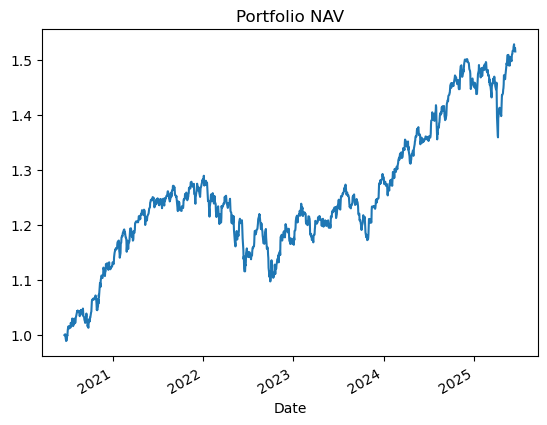

In [5]:
# Step 4: NAV for the portfolio
weights_series = pd.Series(weights, index=price_data.columns)
normalized_prices = price_data / price_data.iloc[0]
portfolio_nav = normalized_prices.dot(weights_series)

# Step 5: Visualizing the Portfolio NAV
portfolio_nav.plot(title="Portfolio NAV")
portfolio_nav

In [6]:
# Step 6 Calculate Log return 

log_return = np.log(portfolio_nav / portfolio_nav.shift(1)).dropna()
log_return

Date
2020-06-22    0.001416
2020-06-23    0.000021
2020-06-24   -0.006665
2020-06-25   -0.002743
2020-06-26   -0.002850
                ...   
2025-06-11    0.001685
2025-06-12    0.001380
2025-06-13   -0.008157
2025-06-16    0.003677
2025-06-17   -0.004111
Length: 1289, dtype: float64

## Model 1: LogisticRegression

In [7]:
# Step 7 Creat the label of Drawdown for the future event

forward_days = 20
forward_max = portfolio_nav.shift(-forward_days).rolling(forward_days).max()
drawdown = (forward_max - portfolio_nav) / forward_max
threshold = 0.05
y = (drawdown > threshold).astype(int)

In [8]:
# Step 8 Build Features

X = pd.DataFrame(index=portfolio_nav.index)
X["ret_5d"] = portfolio_nav.pct_change(5)                   #过去5个交易日的收益率, 可以反映短期趋势，是一个动量指标。
X["ret_20d"] = portfolio_nav.pct_change(20)                 #过去20天的累计收益率, 代表中期趋势
X["vol_20d"] = portfolio_nav.pct_change().rolling(20).std() #过去20天的滚动波动率，过去20天每日收益率的标准差

# contract the final training dataset
df = pd.concat([X, y.rename("target")], axis=1).dropna()
df

,ret_5d,ret_20d,vol_20d,target
Date,,,,
2020-07-17,0.006905,0.020962,0.004547,0
2020-07-20,0.002097,0.016876,0.004618,0
2020-07-21,0.016059,0.028621,0.005195,0
2020-07-22,0.005190,0.033050,0.004927,0
2020-07-23,0.008278,0.033012,0.004928,0
...,...,...,...,...
2025-06-11,0.010529,0.023514,0.004568,0
2025-06-12,0.011687,0.019162,0.004446,0
2025-06-13,-0.000178,0.005043,0.004728,0


In [9]:
X = df[["ret_5d", "ret_20d", "vol_20d"]]
y = df["target"]
pd.Series(y).value_counts()

# Step 9: Split the test set and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [10]:
# Step 10:  Model Setup and training

base_model = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(class_weight="balanced", solver="liblinear"))
])

base_model.fit(X_train, y_train)

# Predicting the test set
y_pred = base_model.predict(X_test)
y_proba = base_model.predict_proba(X_test)[:, 1]

In [11]:
# Step 11: Model Performance 

acc_train = accuracy_score(y_train, base_model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print (f'Train Accuracy:{acc_train:0.4},Test Accuracy:{acc_test:0.4}')

Train Accuracy:0.7057,Test Accuracy:0.8189


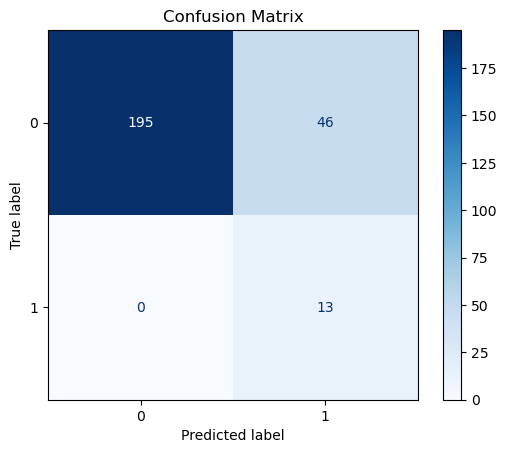

In [12]:
# Display confussion matrix

ConfusionMatrixDisplay.from_estimator(base_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89       241
           1       0.22      1.00      0.36        13

    accuracy                           0.82       254
   macro avg       0.61      0.90      0.63       254
weighted avg       0.96      0.82      0.87       254

Confusion Matrix:
[[195  46]
 [  0  13]]
AUC Score: 0.97765719757421


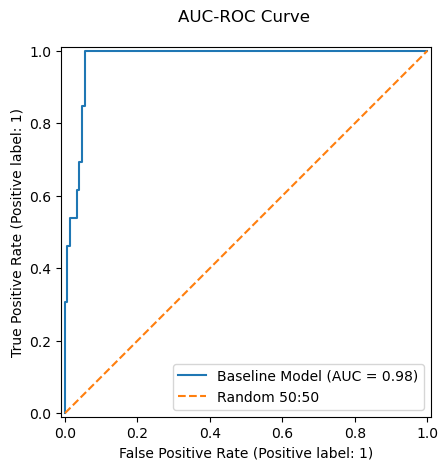

In [13]:
# Moedel Performence 

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("AUC Score:", roc_auc_score(y_test, y_proba))

# Visualize ROC 
display = RocCurveDisplay.from_estimator(base_model, X_test, y_test, name='Baseline Model')
plt.title('AUC-ROC Curve \n')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random 50:50')
plt.legend()
plt.show()

## Model 2: VaR

In [14]:
from typing import List, Optional
from quantmod.timeseries import dailyReturn
from pydantic import BaseModel, Field, confloat   

In [15]:
# Step 1: Define VaR Inputs 

class VaRInputs(BaseModel):
    confidence_level: float = Field(..., ge=0.90, le=1.0, description="The confidence level for the VaR calculation")
    lookback_period: int = Field(..., ge=1, description="Number of historical days for risk estimation")
    num_simulations: int = Field(10000, ge=1000, le=100000, description="Number of Monte Carlo simulations")
    portfolio_weights: Optional[List[confloat(ge=0, le=1)]] = Field(None, description="Weights of assets in the portfolio (None for single stock)")
    portfolio_returns: pd.DataFrame = Field(..., description="Historical returns of portfolio assets or single stock")
    is_single_etf: bool = Field(False, description="Flag to indicate single etf calculation")

    
    class Config:
        arbitrary_types_allowed = True     # Allow Pydantic to accept arbitrary Python types that are not part of the standard Pydantic types.

In [16]:
# Step 2: Define Risk Metrics

class RiskMetrics:
    def __init__(self, inputs: VaRInputs):
        self.confidence_level = inputs.confidence_level
        self.lookback_period = inputs.lookback_period
        self.num_simulations = inputs.num_simulations
        self.returns = inputs.portfolio_returns
        self.is_single_etf = inputs.is_single_etf

        if self.is_single_etf:
            self.weights = np.array([1.0])                                               # Single stock, full weight
        else:
            if inputs.portfolio_weights is None:
                raise ValueError(
                    "Portfolio weights must be provided for portfolio VaR calculation"
                )
            self.weights = np.array(inputs.portfolio_weights)                            #转换权重为 NumPy 数组
            if len(self.weights) != self.returns.shape[1]:                               #验证权重长度是否匹配数据列数
                raise ValueError("Portfolio weights must match the number of assets")
    
    # 参数法-VaR模型, 基于正态分布假设，用历史收益的均值与标准差计算 VaR
    def parametric_var(self) -> float:                           
        mean_returns = np.mean(self.returns, axis=0)
        std = np.std(self.returns, axis=0)
        return self.weights @ norm.ppf(                          # norm.pdf()是正态分布的分位点函数
            1 - self.confidence_level, loc = mean_returns, scale = std
        )
    
    # 历史模拟法-VaR模型, 不对收益分布做任何假设，直接用历史数据的真实分布来估算风险
    def historical_var(self) -> float:                         
        portfolio_returns = (
            self.returns if self.is_single_etf else self.returns @ self.weights
        )
        return np.percentile(portfolio_returns, 100 * (1 - self.confidence_level))

    
    # 蒙特卡洛模拟法-VaR模型
    def monte_carlo_var(self) -> float:                         
        mean_returns = np.mean(self.returns, axis=0)
        cov_matrix = (
            np.cov(self.returns.T)
            if not self.is_single_etf
            else np.var(self.returns, axis=0)
        )

        #生成模拟收益数据
        simulated_returns = (                                          
            np.random.normal(mean_returns, np.sqrt(cov_matrix), self.num_simulations)
            if self.is_single_etf
            else np.random.multivariate_normal(
                mean_returns, cov_matrix, self.num_simulations
            )
        )
        #根据模拟收益计算组合总收益
        portfolio_simulated_returns = (                                
            simulated_returns
            if self.is_single_etf
            else simulated_returns @ self.weights
        )
        return np.percentile(
            portfolio_simulated_returns, 100 * (1 - self.confidence_level)
        )
    
    # 定义ES
    def expected_shortfall(self) -> float:
        portfolio_returns = (
            self.returns if self.is_single_etf else self.returns @ self.weights
        )
        var = self.historical_var()                                  #先调用 historical_var() 得到VaR阈值
        return np.mean(portfolio_returns[portfolio_returns <= var])  #对小于等于 VaR 的收益取平均

In [17]:
# Step 3: Inputs real data 

# Single ETF
single_etf = yf.download("IVV", start=start_date, end=end_date)
single_etf_returns = single_etf["Close"].pct_change().dropna()

# Cbus Super fund 7 ETFs  
log_returns = np.log(price_data / price_data.shift(1)).dropna()
log_returns

/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_1303/3772048077.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  single_etf = yf.download("IVV", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Ticker,AAA.AX,IEM.AX,IFRA,IVV,VAF.AX,VAS.AX,VNQ
Date,,,,,,,
2020-06-22,0.000200,0.000340,0.005082,0.007142,-0.000379,-0.000132,-0.000999
2020-06-23,0.000200,0.001867,-0.002538,0.004063,-0.000947,0.001057,-0.004133
2020-06-24,0.000000,0.008610,-0.027481,-0.025579,-0.000569,0.001847,-0.028902
2020-06-25,-0.000100,-0.012347,0.005081,0.010427,0.001326,-0.023609,0.012691
2020-06-26,-0.000100,0.008642,-0.018227,-0.024147,0.000379,0.013673,-0.019380
...,...,...,...,...,...,...,...
2025-06-11,0.000000,0.010230,0.000000,-0.002842,-0.000215,0.000656,-0.005414
2025-06-12,0.000399,0.001492,0.001643,0.003634,0.002787,-0.003002,0.004862
2025-06-13,0.000199,-0.015843,-0.010726,-0.011142,0.003846,-0.002257,-0.009749


In [18]:
# Step 4: Calculate the VaR and CVaR for the given confidence level 

# Portfolio 
portfolio_risk_metrics = RiskMetrics(
    VaRInputs(
        confidence_level = 0.95,
        lookback_period = 252,
        num_simulations = 10000,
        portfolio_weights = weights,
        portfolio_returns = log_returns,
        is_single_etf=False,
    )
)

# Single ETF 
single_etf_risk_metrics = RiskMetrics(
    VaRInputs(
        confidence_level=0.95,
        lookback_period=252,
        num_simulations=10000,
        portfolio_weights=None,
        portfolio_returns=single_etf_returns,
        is_single_etf=True,
    )
)

print("Portfolio VaR and CVaR for the given confidence level")
print(f"Parametric VaR : {portfolio_risk_metrics.parametric_var():.4f}")
print(f"Historical VaR : {portfolio_risk_metrics.historical_var():.4f}")
print(f"Monte Carlo VaR : {portfolio_risk_metrics.monte_carlo_var():.4f}")
print(f"Expected Shortfall : {portfolio_risk_metrics.expected_shortfall():.4f}")

print(f"\nSingle etf ({single_etf}) VaR and CVaR for the given confidence level")
print(f"Parametric VaR : {single_etf_risk_metrics.parametric_var():.4f}")
print(f"Historical VaR : {single_etf_risk_metrics.historical_var():.4f}")
print(f"Monte Carlo VaR : {single_etf_risk_metrics.monte_carlo_var():.4f}")
print(f"Expected Shortfall : {single_etf_risk_metrics.expected_shortfall():.4f}")

Portfolio VaR and CVaR for the given confidence level
Parametric VaR : -0.0118
Historical VaR : -0.0076
Monte Carlo VaR : -0.0077
Expected Shortfall : -0.0108

Single etf (Price            Close        High         Low        Open    Volume
Ticker             IVV         IVV         IVV         IVV       IVV
Date                                                                
2020-06-19  287.708282  293.170397  286.463519  292.919568   3833900
2020-06-22  289.770569  290.049237  286.064145  287.197442   4186200
2020-06-23  290.950256  293.309747  290.634423  292.334382   3794900
2020-06-24  283.602356  289.575398  281.800229  288.934434   5060800
2020-06-25  286.575043  286.881577  280.945726  283.007953   6432400
...                ...         ...         ...         ...       ...
2025-06-11  602.428955  606.107472  600.355412  605.250163  20207000
2025-06-12  604.622131  604.771628  600.594668  601.093111   6968300
2025-06-13  597.922974  602.887513  596.527368  599.587819   7231400


In [19]:
# Annualize Portfolio VaR 
daily_var = abs(portfolio_risk_metrics.parametric_var())
annual_var = daily_var * np.sqrt(252)
print(f"Annualized Parametric VaR: {annual_var:.2%}")


Annualized Parametric VaR: 18.76%


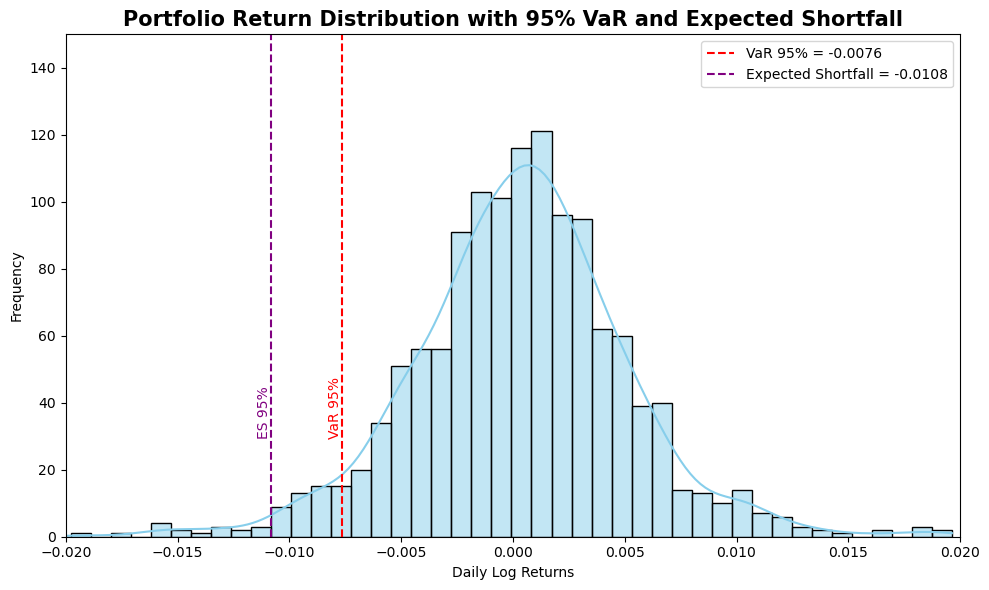

In [27]:
# Visulize the result 

import seaborn as sns

portfolio_returns = np.dot(log_returns, weights)
portfolio_returns_df = pd.Series(portfolio_returns, index=log_returns.index, name="Portfolio")

var_95 = portfolio_risk_metrics.historical_var()
es_95 = portfolio_risk_metrics.expected_shortfall()


plt.figure(figsize=(10, 6))
sns.histplot(portfolio_returns_df, bins=50, kde=True, color="skyblue", edgecolor="black")

# 添加 VaR 线
plt.axvline(x=var_95, color='red', linestyle='--', label=f'VaR 95% = {var_95:.4f}')

# 添加 ES 线
plt.axvline(x=es_95, color='purple', linestyle='--', label=f'Expected Shortfall = {es_95:.4f}')


plt.title("Portfolio Return Distribution with 95% VaR and Expected Shortfall",fontsize=15, fontweight='bold')
plt.xlabel("Daily Log Returns")
plt.xlim(-0.02, 0.02)  # 调整宽度
plt.ylim(0, 150)  # 调整高度
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.text(var_95, 30, 'VaR 95%', rotation=90, color='red', ha='right')
plt.text(es_95, 30, 'ES 95%', rotation=90, color='purple', ha='right')
plt.show()

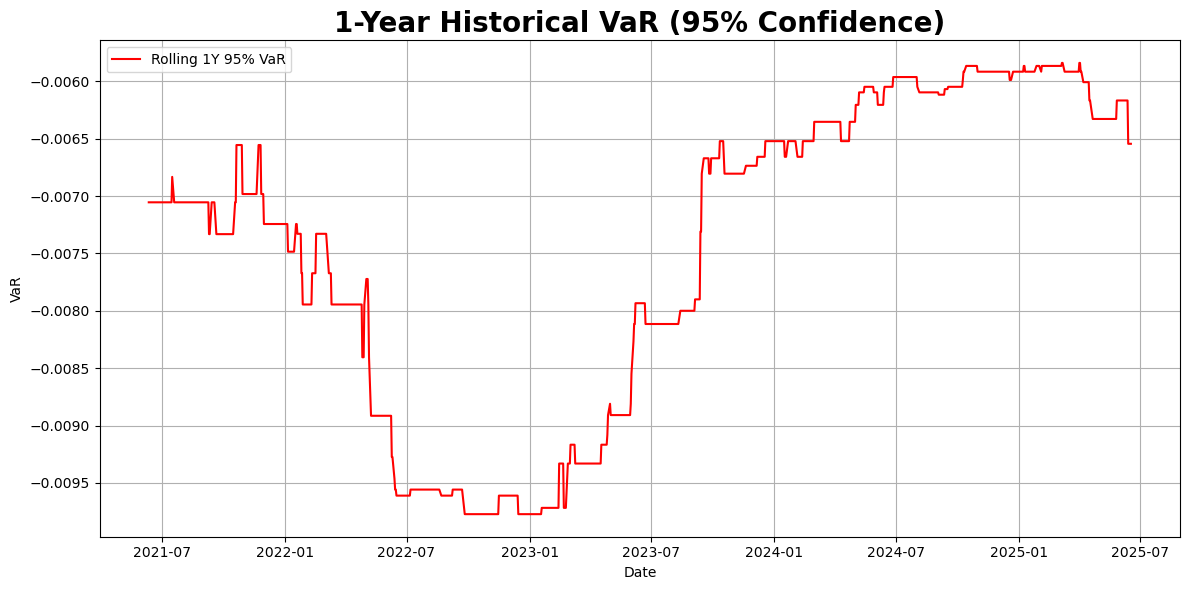

In [24]:
# Rolling 1-Year Historical VaR

window = 252  
rolling_var = portfolio_returns_df.rolling(window).apply(
    lambda x: np.percentile(x, 5)  
)

plt.figure(figsize=(12, 6))
plt.plot(rolling_var, label='Rolling 1Y 95% VaR', color='red')
plt.title('1-Year Historical VaR (95% Confidence)',fontsize=20, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
